In [53]:
# Add the directory containing api_connection.py to the system path
import sys
import os
from pathlib import Path
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace, entropy, Statevector, shannon_entropy
from qiskit_experiments.library import StateTomography
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
sys.path.append(str(Path.cwd() / "bachelor_thesis"))
from api_connection import QiskitService
from qiskit_aer import AerSimulator  # For simulation comparison


In [57]:
#backend = AerProvider().get_backend("qasm_simulator")
service  = QiskitService(str(Path.cwd() / ".env"))
backend = service.get_least_busy_backend()
#backend = service.connect_to_backend("ibm_sherbrooke")  # For testing purposes, using a simulator
print(backend)

Connected to IBM Quantum.
<IBMBackend('ibm_brisbane')>


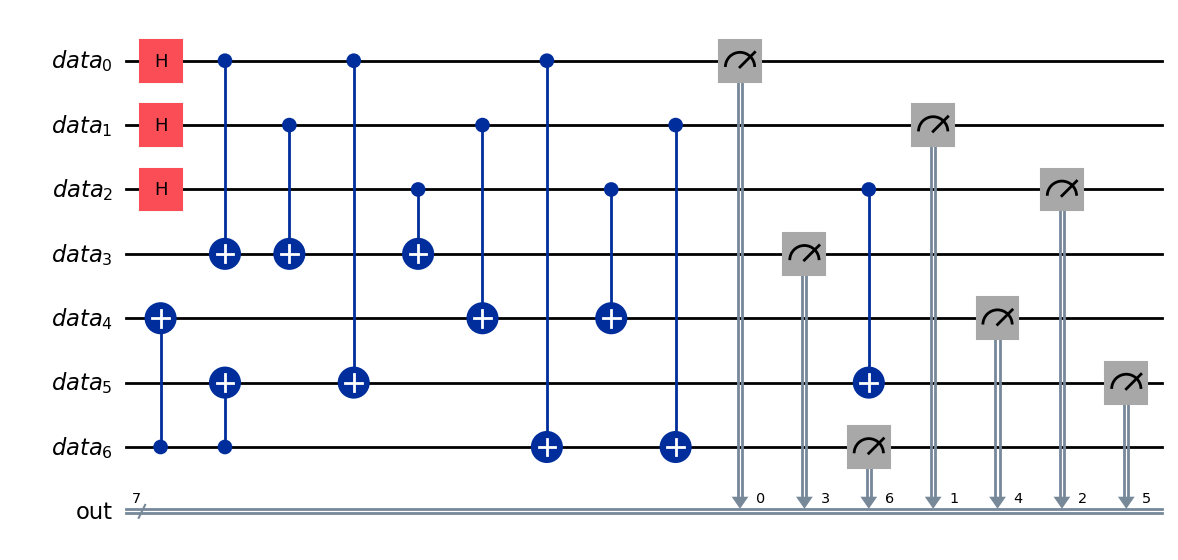

In [49]:
# Define quantum and classical registers
data = QuantumRegister(7, 'data')          # 7 data qubits for the encoded state
logical_out = ClassicalRegister(7, 'out')  # Changed to 7 bits to match classical version

# Initialize the quantum circuit
circuit = QuantumCircuit(data, logical_out)

# Step 1: Encode the logical |0_L⟩ state
circuit.h(data[0])
circuit.h(data[1])
circuit.h(data[2])
circuit.cx(data[6], data[4])

circuit.cx(data[6], data[5])
circuit.cx(data[0], data[3])
circuit.cx(data[1], data[3])
circuit.cx(data[0], data[5])
circuit.cx(data[2], data[3])
circuit.cx(data[1], data[4])
circuit.cx(data[0], data[6])
circuit.cx(data[2], data[4])
circuit.cx(data[1], data[6])
circuit.cx(data[2], data[5])

#circuit.draw(output='latex_source', filename='circuit0.tex', initial_state=True)
#circuit.barrier()
#
# Step 6: Measure all data qubits to verify correction
for i in range(7):
    circuit.measure(data[i], logical_out[i])  # Measure each qubit into its own bit
circuit.draw(output='mpl')

In [50]:
logic_1 = ['1111111', '0101010', '1001100', '0011001', '1110000', '0100101', '1000011', '0010110']
logic_0 = ["0000000", "1010101", "0110011", "1100110", "0001111", "1011010", "0111100", "1101001"]
# Simulation parameters
simulator = AerSimulator()  # Try default simulator first
NUM_SHOTS = 10000
classic_job = simulator.run(circuit, shots=NUM_SHOTS)
classic_result = classic_job.result()
counts = classic_result.get_counts()
CodeWord = list(counts.keys())
print(counts)
print(CodeWord)

{'0111100': 1272, '0110011': 1246, '1011010': 1242, '0000000': 1205, '1010101': 1308, '1101001': 1297, '0001111': 1215, '1100110': 1215}
['0111100', '0110011', '1011010', '0000000', '1010101', '1101001', '0001111', '1100110']


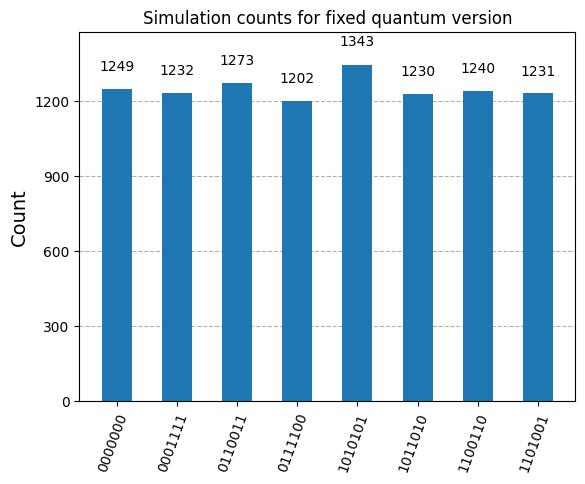

In [36]:
plot_histogram(classic_result.get_counts(), title='Simulation counts for fixed quantum version')

In [56]:
# Set up the preset pass manager with optimization level 0
preset_manager = generate_preset_pass_manager(backend=backend, 
                                  optimization_level=3)
preset_circuit = preset_manager.run(circuit)

# Run the circuit using the Sampler
job = Sampler(mode=backend).run([(preset_circuit)], shots= NUM_SHOTS)
print(f"Job ID: {job.job_id()}, \n Job Status: {job.status()}")

AttributeError: 'list' object has no attribute 'configuration'

In [47]:
# Get and display results
result = job.result()
pub_result = result[0]
#syndrome z finds bit flips
print(f"Counts for the 'out' output register: {pub_result.data.out.get_counts()}")

Counts for the 'out' output register: {'1111001': 144, '1010110': 37, '0010111': 176, '0000111': 163, '1101001': 393, '1010101': 440, '1000001': 58, '1001001': 69, '0001111': 612, '0010011': 79, '1111110': 66, '1011101': 226, '1000000': 42, '1111010': 96, '0110011': 468, '0110001': 30, '0000000': 204, '1001110': 32, '1110110': 146, '0111010': 16, '1100001': 306, '0100101': 28, '1001101': 114, '1111111': 18, '1000110': 86, '0111100': 251, '0100011': 310, '0101111': 106, '1111011': 32, '0111011': 180, '1000101': 183, '1110001': 86, '0001000': 151, '1111100': 64, '1000100': 28, '0110100': 150, '0011111': 238, '0101100': 94, '1010010': 153, '1001010': 161, '0001100': 28, '1110011': 67, '1011001': 26, '0011101': 63, '1101010': 47, '0101101': 9, '0010000': 100, '0101011': 121, '0010001': 12, '1100110': 341, '1100101': 38, '0101001': 48, '0000011': 59, '0010101': 66, '0011010': 45, '0100000': 47, '1011010': 343, '0110010': 18, '1010111': 53, '1011111': 47, '1000111': 35, '0101010': 20, '01111

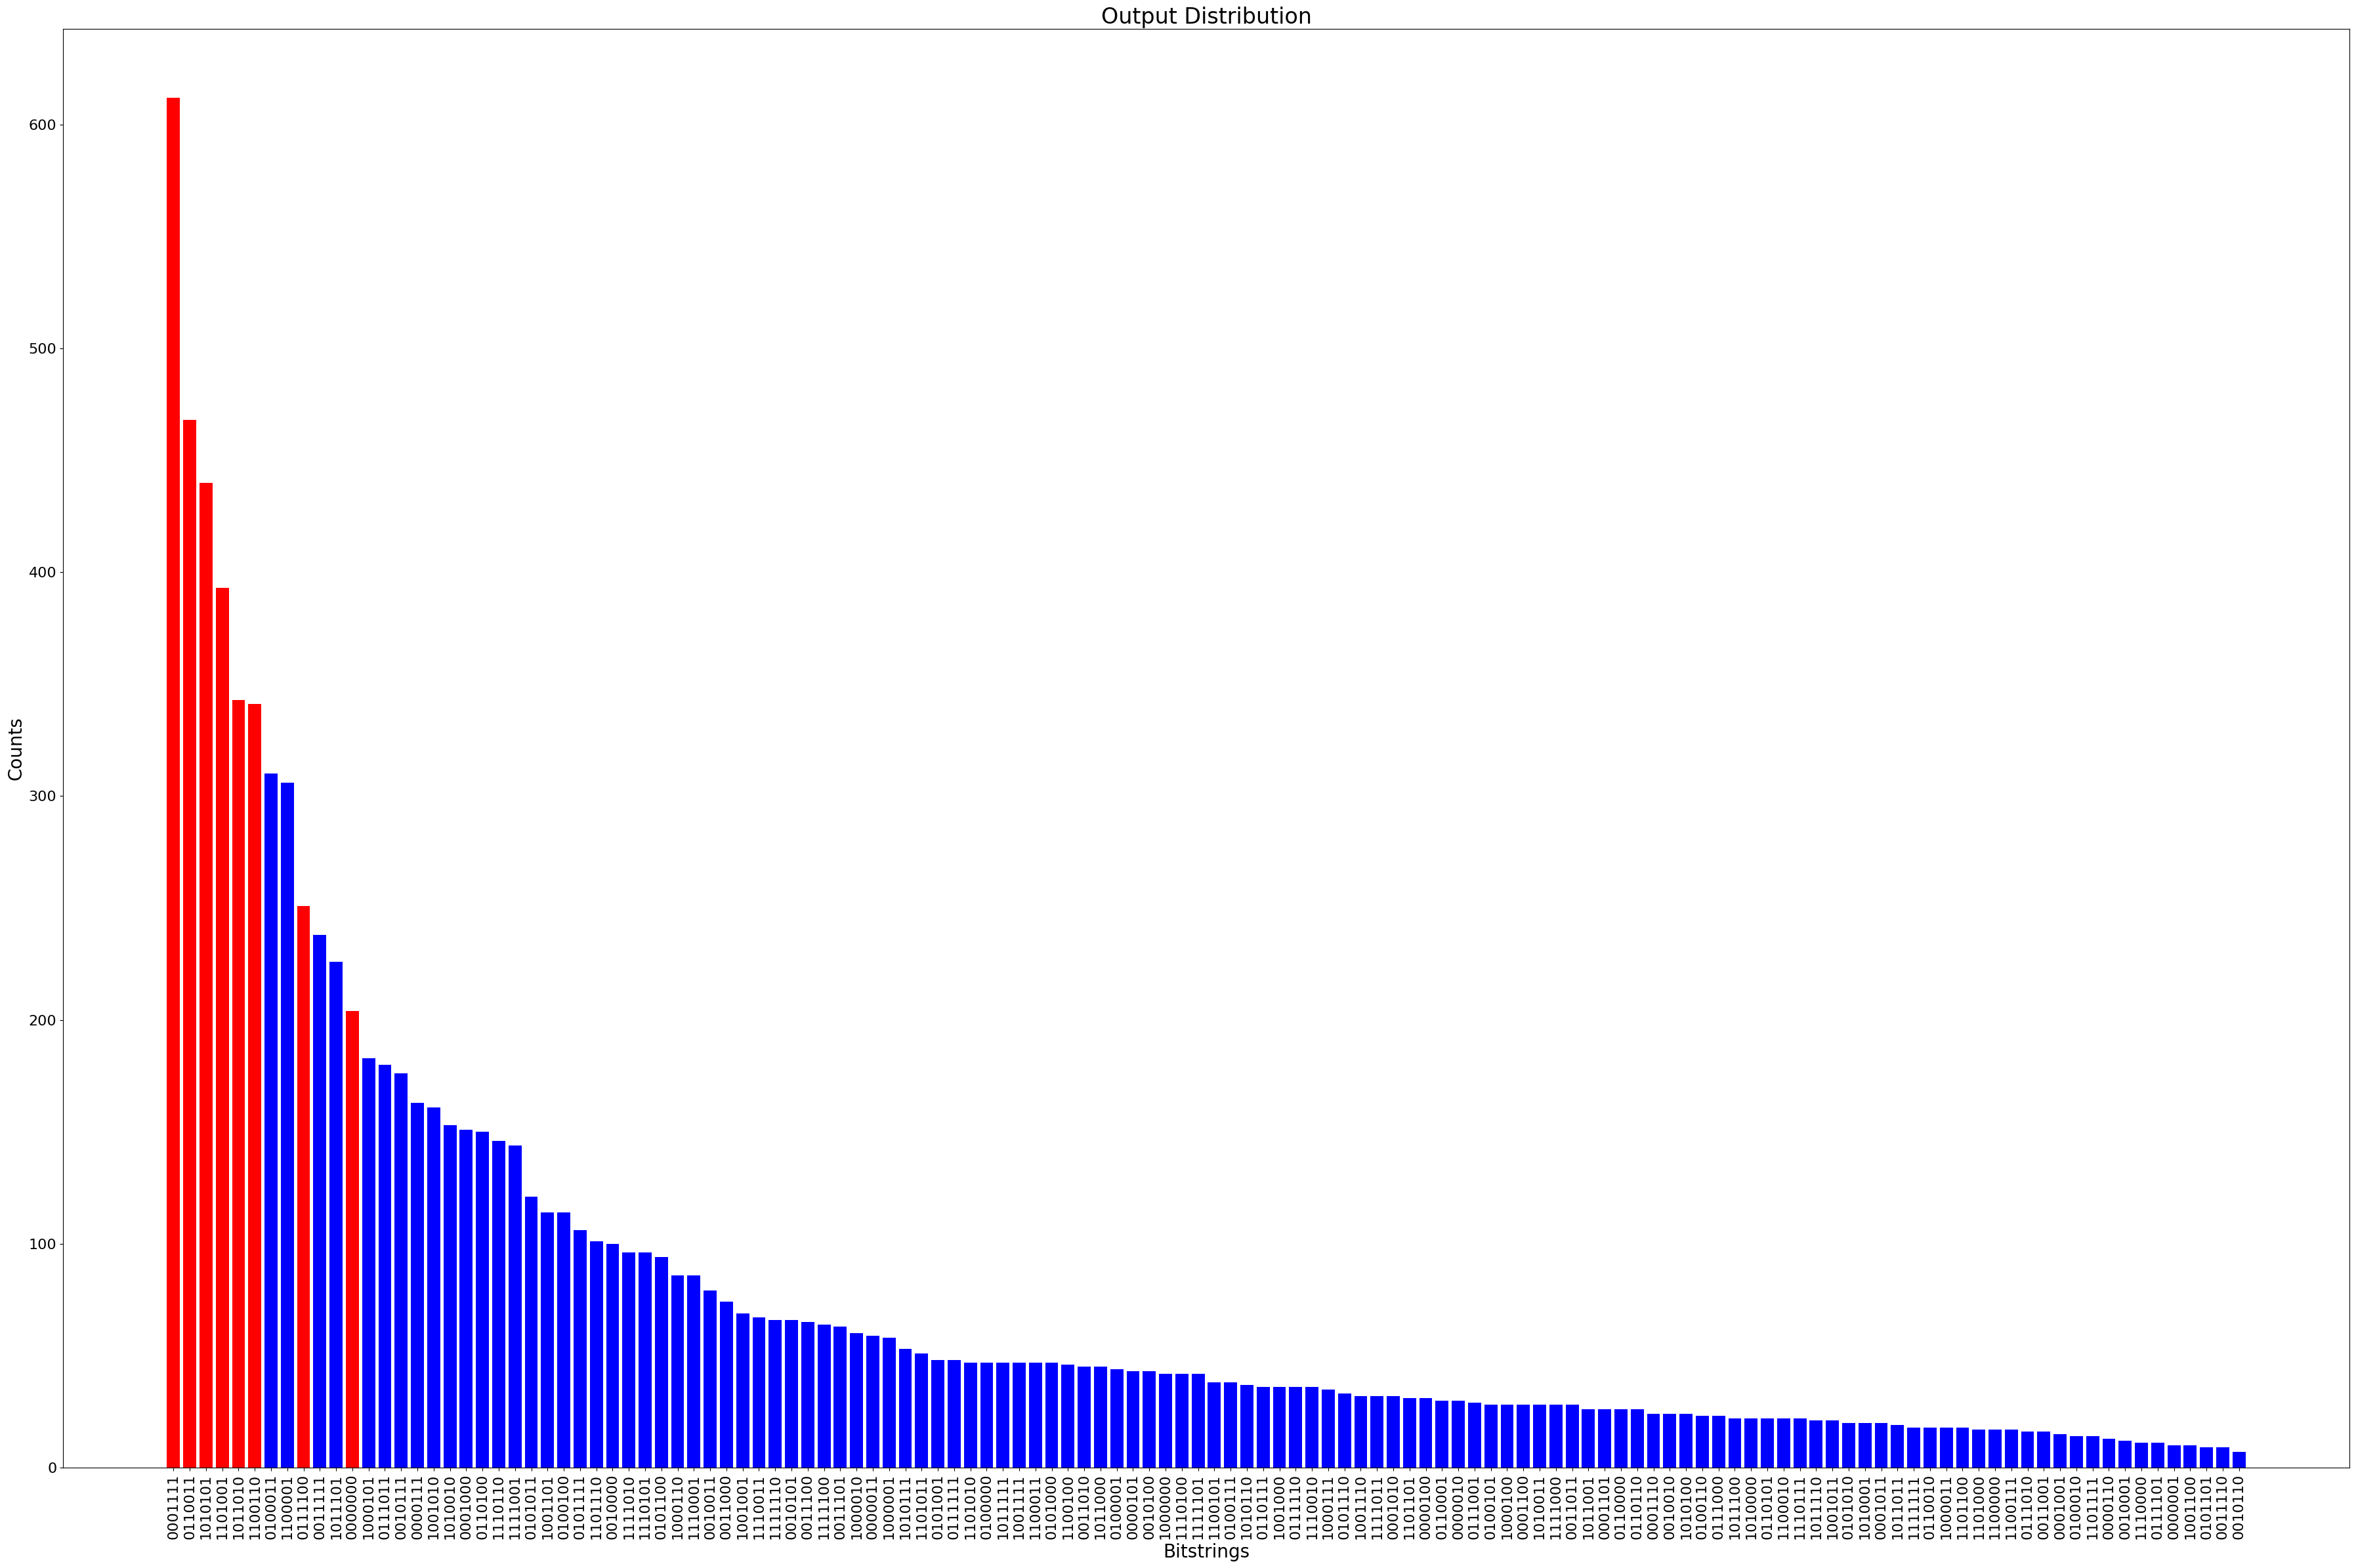

In [39]:
import matplotlib.pyplot as plt

# Define the outputs to highlight in red
steane_code_logic_0 = {"0000000", "1010101", "0110011", "1100110", "0001111", "1011010", "0111100", "1101001"}

# Get the counts data
counts = pub_result.data.out.get_counts()

# Sort the counts for better visualization
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Prepare data for plotting
keys = list(sorted_counts.keys())
values = list(sorted_counts.values())
colors = ["red" if key in steane_code_logic_0 else "blue" for key in keys]

# Create the bar chart
plt.figure(figsize=(36, 24))
plt.bar(keys, values, color=colors)

# Add labels and title
plt.xlabel("Bitstrings", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.title("Output Distribution", fontsize=24)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

In [40]:
# Convert logical_out BitArray to a probability vector

# Get counts from logical_out
logical_out_counts = pub_result.data.out.get_counts()

# Calculate total shots
total_shots = sum(logical_out_counts.values())

# Create a probability vector
probability_vector = [count / total_shots for count in logical_out_counts.values()]

# Print the probability vector in a readable format
#print("Probability vector:")
#for i, prob in enumerate(probability_vector):
#    print(f"  Outcome {i + 1}: {prob:.6f}")

# Calculate and print the Shannon entropy
entropy_value = shannon_entropy(probability_vector)
print(f"\nShannon Entropy: {entropy_value:.6f}")


Shannon Entropy: 6.205813
